In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ctgan import CTGAN
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import faiss

In [2]:
df_A = pd.read_csv("original.csv")
df_B = pd.read_csv("challenge.csv")

In [3]:
df_B

,Identifier,Name,Age,Occupation,City_Tier,Dependents,Income,Rent,Loan_Repayment,Insurance,Groceries,Transport,Eating_Out,Entertainment,Utilities,Healthcare,Education,Miscellaneous
0,bb0fe6d06cc153b8635440fd3638b589,c8b4c30e6fcdbaa4e0d1c3db732cb222,23,Retired,Tier_2,3,25166.00,5065.18,0.22,568.09,3126.91,2002.14,757.03,815.29,1940.71,938.04,1986.18,485.90
1,9f8921b372a89bdb616b822e3137e87d,afdff0db61720290465c6e30ac45ba92,48,Self_Employed,Tier_2,0,21709.45,4313.33,1.66,468.73,2534.51,1457.48,814.66,947.51,1045.55,757.98,1449.22,377.18
2,6b8de0031bb7c14e2d4a9305c5c50b23,2b379af688ea4197b678316f376d1764,30,Retired,Tier_2,2,40669.25,8160.43,4471.97,1201.45,6021.28,2998.56,1275.74,1737.36,2732.39,1699.98,2335.79,616.21
3,51693f158b2adacfc664eecc6681caa2,76fb68f64365f4c4d4ae96e208a3550c,37,Retired,Tier_2,3,34369.50,6747.60,2469.81,1298.66,4881.52,1691.44,1324.01,1509.83,2297.28,1335.21,2824.56,859.47
4,3f37d5d38725084a3f9fc2e3324a5132,6bdce18db7dad925adcba8f31fe46c6b,22,Student,Tier_2,1,28979.79,5809.44,4.36,695.69,3500.11,2165.89,597.55,1034.45,2193.08,1254.94,1733.76,367.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1a8fa671b6e6bad49789ca05c56d9750,8f668faf37bdbab67e0463f8c8ff3a63,32,Self_Employed,Tier_1,0,17934.71,5492.32,2.31,610.88,2270.07,1262.74,352.94,706.29,857.86,895.03,4.48,392.86
19996,b0263ebcb06e8c4fba4960d2f3da286a,dfe7f36441ca9c945eb3cbe907f58eb9,44,Retired,Tier_2,3,15492.62,3089.49,1683.48,622.92,1817.64,1071.87,330.01,382.79,1003.65,498.65,1010.99,335.37
19997,e26e6a25e131f0e9bffa5710fceaf68c,91c9a977c3f7c70f42196db6ca43996b,27,Student,Tier_1,1,17109.41,5101.05,0.70,706.10,2529.46,992.37,601.97,341.67,1233.62,821.84,932.97,241.89
19998,0ae485a890e146bdcf49628eecd61b26,776662465577abbe32e4e139099c9efe,31,Student,Tier_2,1,35336.89,7271.77,2282.85,1152.68,4989.40,2180.83,1605.64,1598.88,1902.23,1538.14,3510.35,921.99


In [4]:
df_A

,Identifier,Name,Age,Occupation,City_Tier,Dependents,Income,Rent,Loan_Repayment,Insurance,Groceries,Transport,Eating_Out,Entertainment,Utilities,Healthcare,Education,Miscellaneous
0,0,Gopal Palla,49,Self_Employed,Tier_1,0,44637.25,13391.17,0.00,2206.49,6658.77,2636.97,1651.80,1536.18,2911.79,1546.91,0.00,831.53
1,1,Pranav Nanda,34,Retired,Tier_2,2,26858.60,5371.72,0.00,869.52,2818.44,1543.02,649.38,1050.24,1626.14,1137.35,1551.72,564.24
2,2,Neelima Sengupta,35,Student,Tier_3,1,50367.61,7555.14,4612.10,2201.80,6313.22,3221.40,1513.81,1723.31,3368.46,2178.52,3160.03,628.37
3,3,Balendra Babu,21,Self_Employed,Tier_3,0,101455.60,15218.34,6809.44,4889.42,14690.15,7106.13,5040.25,2858.19,6128.55,4571.12,0.00,2526.06
4,4,Anamika Char,52,Professional,Tier_2,4,24875.28,4975.06,3112.61,635.91,3034.33,1276.16,692.83,660.19,1092.69,1169.10,1445.22,515.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,Gauri Khatri,51,Self_Employed,Tier_1,4,40913.47,12274.04,7703.85,1646.80,5477.40,2084.23,1945.98,1210.45,1641.05,1938.82,2841.32,986.20
19996,19996,Yauvani Varty,21,Student,Tier_2,1,90295.77,18059.15,0.00,2770.59,13118.22,4633.11,3770.92,2356.41,5471.74,2726.60,5284.43,1379.42
19997,19997,Aradhana Lalla,30,Professional,Tier_2,1,40604.57,8120.91,8089.61,1548.56,6018.28,2493.56,896.29,1571.91,2792.62,2025.40,3910.47,869.05
19998,19998,Ekantika Dutta,27,Professional,Tier_1,2,118157.82,35447.35,12345.91,4735.67,16392.44,8248.24,2545.42,4721.79,9104.61,5304.36,6237.32,2471.02


In [5]:
df_A=df_A.drop(['Name','Identifier'],axis=1)

In [6]:
df_A

,Age,Occupation,City_Tier,Dependents,Income,Rent,Loan_Repayment,Insurance,Groceries,Transport,Eating_Out,Entertainment,Utilities,Healthcare,Education,Miscellaneous
0,49,Self_Employed,Tier_1,0,44637.25,13391.17,0.00,2206.49,6658.77,2636.97,1651.80,1536.18,2911.79,1546.91,0.00,831.53
1,34,Retired,Tier_2,2,26858.60,5371.72,0.00,869.52,2818.44,1543.02,649.38,1050.24,1626.14,1137.35,1551.72,564.24
2,35,Student,Tier_3,1,50367.61,7555.14,4612.10,2201.80,6313.22,3221.40,1513.81,1723.31,3368.46,2178.52,3160.03,628.37
3,21,Self_Employed,Tier_3,0,101455.60,15218.34,6809.44,4889.42,14690.15,7106.13,5040.25,2858.19,6128.55,4571.12,0.00,2526.06
4,52,Professional,Tier_2,4,24875.28,4975.06,3112.61,635.91,3034.33,1276.16,692.83,660.19,1092.69,1169.10,1445.22,515.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,51,Self_Employed,Tier_1,4,40913.47,12274.04,7703.85,1646.80,5477.40,2084.23,1945.98,1210.45,1641.05,1938.82,2841.32,986.20
19996,21,Student,Tier_2,1,90295.77,18059.15,0.00,2770.59,13118.22,4633.11,3770.92,2356.41,5471.74,2726.60,5284.43,1379.42
19997,30,Professional,Tier_2,1,40604.57,8120.91,8089.61,1548.56,6018.28,2493.56,896.29,1571.91,2792.62,2025.40,3910.47,869.05
19998,27,Professional,Tier_1,2,118157.82,35447.35,12345.91,4735.67,16392.44,8248.24,2545.42,4721.79,9104.61,5304.36,6237.32,2471.02


In [7]:
categorical_cols = df_A.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_A.select_dtypes(include=['int64', 'float64']).columns.tolist()
all_cols = numerical_cols + categorical_cols


In [8]:
df_A = df_A[all_cols]
df_B = df_B[all_cols]


In [9]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [10]:
X_A_enc = preprocessor.fit_transform(df_A)

In [11]:
X_B_enc = preprocessor.transform(df_B)

In [ ]:
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encoder architecture
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


class TripletTabularDataset(Dataset):
    def __init__(self, X_anchor, X_positive):
        self.X_anchor = torch.tensor(X_anchor, dtype=torch.float32)
        self.X_positive = torch.tensor(X_positive, dtype=torch.float32)
        self.length = self.X_anchor.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        anchor = self.X_anchor[idx]
        positive = self.X_positive[idx]
        neg_idx = random.choice([i for i in range(self.length) if i != idx])
        negative = self.X_positive[neg_idx]
        return anchor, positive, negative

# Prepare data
triplet_dataset = TripletTabularDataset(X_B_enc, X_A_enc)
triplet_loader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)

In [ ]:
latent_dim = 300
encoder = Encoder(input_dim=X_A_enc.shape[1], latent_dim=latent_dim).to(device)
triplet_loss_fn = nn.TripletMarginLoss(margin=0.1)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)


for epoch in range(100):
    total_loss = 0
    for anchor, positive, negative in triplet_loader:
        # Move data to device
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        z_anchor = encoder(anchor)
        z_positive = encoder(positive)
        z_negative = encoder(negative)

        # Loss and optimization
        loss = triplet_loss_fn(z_anchor, z_positive, z_negative)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Triplet Loss: {total_loss / len(triplet_loader):.4f}")

Epoch 1, Triplet Loss: 0.1762
Epoch 2, Triplet Loss: 0.1294
Epoch 3, Triplet Loss: 0.1175
Epoch 4, Triplet Loss: 0.1110
Epoch 5, Triplet Loss: 0.1068
Epoch 6, Triplet Loss: 0.1055
Epoch 7, Triplet Loss: 0.1040
Epoch 8, Triplet Loss: 0.1026
Epoch 9, Triplet Loss: 0.1022
Epoch 10, Triplet Loss: 0.1018
Epoch 11, Triplet Loss: 0.1008
Epoch 12, Triplet Loss: 0.1005
Epoch 13, Triplet Loss: 0.1002
Epoch 14, Triplet Loss: 0.0998
Epoch 15, Triplet Loss: 0.0995
Epoch 16, Triplet Loss: 0.0997
Epoch 17, Triplet Loss: 0.0998
Epoch 18, Triplet Loss: 0.0991
Epoch 19, Triplet Loss: 0.0994
Epoch 20, Triplet Loss: 0.0993
Epoch 21, Triplet Loss: 0.0992
Epoch 22, Triplet Loss: 0.0994
Epoch 23, Triplet Loss: 0.0996
Epoch 24, Triplet Loss: 0.0988
Epoch 25, Triplet Loss: 0.0991
Epoch 26, Triplet Loss: 0.0984
Epoch 27, Triplet Loss: 0.0991
Epoch 28, Triplet Loss: 0.0988
Epoch 29, Triplet Loss: 0.0986
Epoch 30, Triplet Loss: 0.0985
Epoch 31, Triplet Loss: 0.0984
Epoch 32, Triplet Loss: 0.0977
Epoch 33, Triplet

In [ ]:

torch.save(encoder.state_dict(), "triplet_encoder_model_100.pth")
print("Model saved as triplet_encoder_model.pth")


Model saved as triplet_encoder_model.pth


In [ ]:

encoder = Encoder(input_dim=X_A_enc.shape[1], latent_dim=latent_dim)
encoder.load_state_dict(torch.load("triplet_encoder_model_100.pth"))
encoder.to(device)
encoder.eval()  


Encoder(
  (net): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=300, bias=True)
  )
)

In [15]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import faiss
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import seaborn as sns


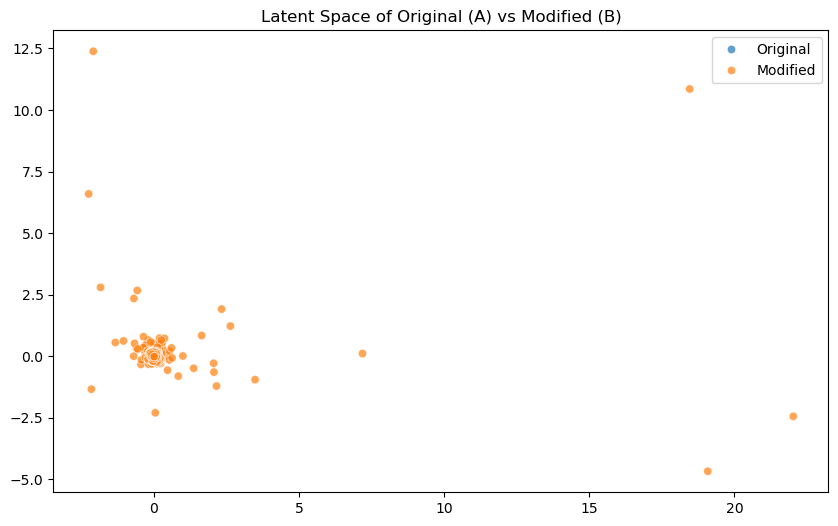

In [ ]:
with torch.no_grad():
    X_A_tensor = torch.tensor(X_A_enc, dtype=torch.float32).to(device)
    X_B_tensor = torch.tensor(X_B_enc, dtype=torch.float32).to(device)

    Z_A = encoder(X_A_tensor).cpu().numpy() 
    Z_B = encoder(X_B_tensor).cpu().numpy()

Z_all = np.vstack([Z_A, Z_B])
labels = ['Original'] * len(Z_A) + ['Modified'] * len(Z_B)

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_all)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=Z_2d[:, 0], y=Z_2d[:, 1], hue=labels, alpha=0.7)
plt.title("Latent Space of Original (A) vs Challenge (B)")
plt.show()

In [17]:
df_A = pd.read_csv("original.csv")
df_B = pd.read_csv("challenge.csv")

In [ ]:
import faiss
import numpy as np
import pandas as pd


faiss_index = faiss.IndexFlatL2(latent_dim)
faiss_index.add(Z_A.astype(np.float32)) 


D, indices = faiss_index.search(Z_B.astype(np.float32), k=5000) 

match_data = []
used_A_indices = set()

epsilon = 1e-6 

for i in range(len(Z_B)):
    for j in range(5000): 
        a_idx = indices[i][j]
        if a_idx not in used_A_indices:
            dist = D[i][j]
            confidence = 1 / (1 + dist)

            # Reject confidence = 1
            if abs(confidence - 1) < epsilon:
                continue

            match_data.append({
                "B_index": i,
                "A_index": a_idx,
                "match_confidence": confidence
            })
            used_A_indices.add(a_idx)
            break  # stop once we find a unique match

# Step 4: Build final matched DataFrame
match_df = pd.DataFrame(match_data)

# Attach info from original datasets
final_matched = match_df.merge(df_B.reset_index(), left_on="B_index", right_index=True)
final_matched = final_matched.merge(df_A[["Identifier", "Name"]].reset_index(), left_on="A_index", right_index=True)

# Step 5: Save final deduplicated matches
final_matched.to_csv("final_faiss_matched_no_duplicates2.csv", index=False)
print(f"Matching complete. {len(final_matched)} unique matches saved.")


Matching complete. 19906 unique matches saved.


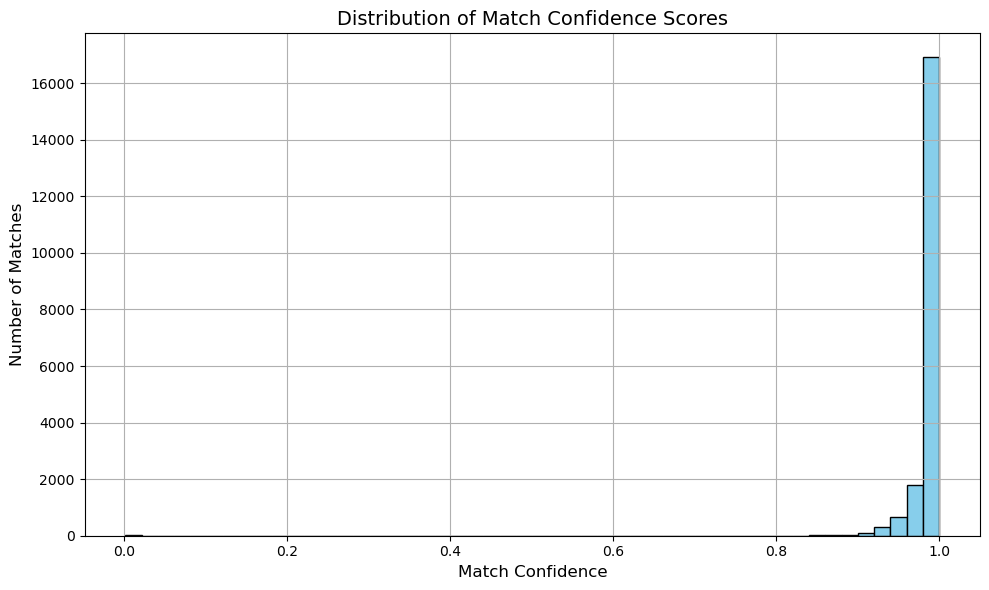

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(final_matched["match_confidence"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Match Confidence Scores", fontsize=14)
plt.xlabel("Match Confidence", fontsize=12)
plt.ylabel("Number of Matches", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

final_matched["is_suspicious"] = final_matched["match_confidence"] < 0.85
# Count suspicious cases
print(f" Suspicious matches (confidence < 0.85): {final_matched['is_suspicious'].sum()} out of {len(final_matched)}")


 Suspicious matches (confidence < 0.85): 120 out of 19906


In [21]:
approx_accuracy = len(final_matched) / len(df_B) * 100
print(f"Approximate Accuracy (no duplicate A-IDs): {approx_accuracy:.2f}%")


Approximate Accuracy (no duplicate A-IDs): 99.53%


In [44]:
mean_confidence = final_matched["match_confidence"].mean()
print(f" Mean Match Confidence: {mean_confidence:.4f}")
confidence_accuracy = final_matched["match_confidence"].sum() / len(df_B) * 100
print(f" Confidence-Weighted Accuracy: {confidence_accuracy:.2f}%")
high_conf_thresh = 0.8
high_conf_matches = final_matched[final_matched["match_confidence"] >= high_conf_thresh]
high_conf_rate = len(high_conf_matches) / len(df_B) * 100
print(f" Matches with Confidence ≥ {high_conf_thresh}: {high_conf_rate:.2f}%")


 Mean Match Confidence: 0.9867
 Confidence-Weighted Accuracy: 98.21%
 Matches with Confidence ≥ 0.8: 99.00%
